<a href="https://colab.research.google.com/github/graphtrek/stockforecast/blob/main/graphtrek_29.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# install necessary modules
!pip install yfinance
!pip install plotly
!pip install ta
!pip install paramiko

In [5]:
import os, time
import yfinance as yf
import requests
import numpy as np
import math
import time
import json
import paramiko

from pathlib import Path
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta

import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MAE
from tensorflow.keras.layers import Dense, Dropout

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import plotly.graph_objects as go
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from matplotlib import pyplot as plt

from ta.trend import MACD
from ta.momentum import StochasticOscillator
from ta.momentum import RSIIndicator


from tabulate import tabulate
from getpass import getpass

In [6]:
INFO = 1
DEBUG = 2
TRACE = 3
print_level = DEBUG 
nr_of_features = 1
look_forward = 1
epochs = 120
learning_rate=0.0042
np.random.seed(42)
look_back = 14 #  number of past days we want to use to predict 1 day in the future.
split_percent = 0.90 # use 90% of the data  for train

if look_back < 5:
  num_prediction = look_back * 4
else:
  num_prediction = look_back * 2

upload_data = True
tmp_dir = "/content/sample_data"
#model_dir = "/content/sample_data"
#chart_dir = "/content/sample_data"

model_dir = "/content/drive/MyDrive/models"
chart_dir = "/content/drive/MyDrive/models/chart"
#model_dir = "/home/nexys/tmp"
#chart_dir = "/home/nexys/tmp"

In [7]:
if upload_data is True:
    username = input("username:") 
    password = getpass("password:")
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

username:nexys
password:··········


In [8]:
def sftp(username,password,local_path,destination_path):
  try:
    transport = paramiko.Transport(("nexys.hu", 22))
    transport.connect(username = username, password = password)
    transport.use_compression(True)
    sftp = paramiko.SFTPClient.from_transport(transport)
    sftp.put(local_path, destination_path)
    print('sftp local_path:', local_path,'destination_path:',destination_path)
    sftp.close()
    transport.close()
  except:
    print('sftp error local_path:', local_path,'destination_path:',destination_path)
  return None

def upload_to_nexys(ticker,last_date):
  if upload_data is True:
    sftp(username,password,tmp_dir+"/"+ticker.ticker+".html","/home/nexys/vagrant/www/nexys.hu/stonks/"+ticker.ticker + "_"+ str(last_date) + ".html")
    sftp(username,password,tmp_dir+"/"+ticker.ticker+".csv","/home/nexys/graphtrek/stock/"+ticker.ticker + ".csv")
    upload_options_to_nexys(ticker)
    upload_predictions_to_nexys(ticker)
    sftp(username,password,tmp_dir+"/"+ticker.ticker+"_news.csv","/home/nexys/graphtrek/stock/"+ticker.ticker + "_news.csv")
    sftp(username,password,tmp_dir+"/"+ticker.ticker+"_calendar.csv","/home/nexys/graphtrek/stock/"+ticker.ticker + "_calendar.csv")
  else:
    print('upload_to_nexys upload_data is False')
  return None

def upload_options_to_nexys(ticker):
  if upload_data is True:
    sftp(username,password,tmp_dir+"/"+ticker.ticker+"_options.csv","/home/nexys/graphtrek/stock/"+ticker.ticker + "_options.csv")
    sftp(username,password,tmp_dir+"/"+ticker.ticker+"_info.json","/home/nexys/graphtrek/stock/"+ticker.ticker + "_info.json")
  else:
    print('upload_options_to_nexys upload_data is False')
  return None  

def upload_predictions_to_nexys(ticker):
  if upload_data is True:
    sftp(username,password,tmp_dir+"/"+ticker.ticker+"_prediction.csv","/home/nexys/graphtrek/stock/"+ticker.ticker + "_prediction.csv")
    sftp(username,password,tmp_dir+"/"+ticker.ticker+"_test_prediction.csv","/home/nexys/graphtrek/stock/"+ticker.ticker + "_test_prediction.csv")
  else:
    print('upload_predictions_to_nexys upload_data is False')
  return None  

In [9]:
def get_stock_price(ticker, from_date):
  df = yf.download(ticker.ticker, start=from_date, interval="1d")
  #df = df.rename(columns={"Close": "Close1", "Adj Close": "Close"})
  
  #ticker = yf.Ticker(symbol)

  #df = ticker.history(start=from_date, interval="1d")
  #print(df.info())
  df['Date'] = pd.to_datetime(df.index)
  #df['Date'] = df['Date'].apply(mpl_dates.date2num)
  #df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]
  df['EMA21'] = df['Close'].ewm(span=21, adjust=False).mean()
  df['MA20'] =  df['Close'].rolling(window=20).mean()
  df['MA50'] = df['Close'].rolling(window=50).mean()
  df['MA100'] = df['Close'].rolling(window=100).mean()
  df['MA200'] = df['Close'].rolling(window=200).mean()
  df['MA300'] = df['Close'].rolling(window=200).mean()

  macd, soch, rsi = indicators(df)
  df['RSI'] = rsi.rsi().to_numpy()
  df['MACD_DIFF'] = macd.macd_diff().to_numpy()
  df['MACD'] = macd.macd().to_numpy()
  df['MACD_SIGNAL'] = macd.macd_signal().to_numpy()
  df.to_csv(tmp_dir + '/' + ticker.ticker + '.csv', index=False)
  print('Get Stock Price', ticker.ticker, 'done.')
  return df

def is_support(df,i):
  cond1 = df['Low'][i] < df['Low'][i-1] 
  cond2 = df['Low'][i] < df['Low'][i+1] 
  cond3 = df['Low'][i+1] < df['Low'][i+2] 
  cond4 = df['Low'][i-1] < df['Low'][i-2]
  return (cond1 and cond2 and cond3 and cond4)

def is_resistance(df,i):
  cond1 = df['High'][i] > df['High'][i-1] 
  cond2 = df['High'][i] > df['High'][i+1] 
  cond3 = df['High'][i+1] > df['High'][i+2] 
  cond4 = df['High'][i-1] > df['High'][i-2]
  return (cond1 and cond2 and cond3 and cond4)

def is_far_from_level(value, levels, df):
    ave =  np.mean(df['High'] - df['Low'])
    return np.sum([abs(value - level) < ave for level in levels]) == 0

def findNearestGreaterThan(searchVal, inputData):
    diff = inputData - searchVal
    diff[diff<0] = np.inf
    idx = diff.argmin()
    return inputData[idx]


def findNearestLessThan(searchVal, inputData):
    diff = inputData - searchVal
    diff[diff>0] = -np.inf
    idx = diff.argmax()
    return inputData[idx]

def indicators(chart_df):
  # MACD
  macd = MACD(close=chart_df['Close'], 
            window_slow=26,
            window_fast=12, 
            window_sign=9)
  # stochastics
  stoch = StochasticOscillator(high=chart_df['High'],
                             close=chart_df['Close'],
                             low=chart_df['Low'],
                             window=14, 
                             smooth_window=3)

  rsi = RSIIndicator(close=chart_df['Close'], window=14)
  return macd, stoch, rsi

# custom function to set fill color
def fillcol(label):
  if label >= 1:
    return 'rgba(0,250,0,0.4)'
  else:
    return 'rgba(250,0,0,0.4)'


In [10]:
def calculate_levels(chart_df):
  levels = []
  low = 0
  high = np.round(chart_df['Close'].max(),1)
  last_day_df = chart_df[-1:]
  last_date = last_day_df['Date'].index[0].date()
  close_price = np.round(last_day_df['Close'][0],1)
  for i in range(2,len(chart_df)-2):
    try:
      if is_support(chart_df,i):
        low = chart_df['Low'][i]
      if is_far_from_level(low, levels, chart_df):
        levels.append(low)
      elif is_resistance(chart_df,i):
        high = chart_df['High'][i]
      if is_far_from_level(high, levels, chart_df):
        levels.append(high)
    except:
      print('calculate_levels error')
  levels = sorted(levels, reverse=True)

  min_level = np.round(findNearestLessThan(close_price,levels),1)
  if(min_level > close_price):
    min_level = np.round(close_price * 0.8,1)

  max_level = np.round(findNearestGreaterThan(close_price,levels),1)
  if(max_level < close_price):
    max_level = np.round(close_price * 1.2,1)

  print('Calculate Levels close_price',close_price,'min_level:',min_level,'max_level:', max_level)
  return levels, close_price, min_level, max_level

In [11]:
def options_chain(ticker):

    #tk = yf.Ticker(symbol)
    # Expiration dates
    exps = ticker.options

    # Get options for each expiration
    options = pd.DataFrame()
    try:
      for e in exps:
          opt = ticker.option_chain(e)
          opt = pd.DataFrame().append(opt.calls).append(opt.puts)
          opt['expirationDate'] = e
          options = options.append(opt, ignore_index=True)

      # Bizarre error in yfinance that gives the wrong expiration date
      # Add 1 day to get the correct expiration date
      options['expirationDate'] = pd.to_datetime(options['expirationDate'])
      options.insert(0,'dte',(options['expirationDate'] - datetime.today()).dt.days + 1)
      options['expirationDate'] = options['expirationDate'].dt.date
      # Boolean column if the option is a CALL x : True if (x > 10 and x < 20) else False
      options.insert(1,'CALL',options['contractSymbol'].str[4:].apply(lambda x: "C" in x))
      
      options[['bid', 
              'ask', 
              'strike', 
              'lastPrice', 
              'volume',
              'change',
              'percentChange',
              'openInterest',
              'impliedVolatility']] = options[[
                                    'bid', 
                                    'ask', 
                                    'strike',
                                    'lastPrice',
                                    'volume',
                                    'change',
                                    'percentChange',
                                    'openInterest',
                                    'impliedVolatility']].apply(pd.to_numeric)
      
      options['spread%'] = np.round(100 - ((options['bid'] / options['ask']) * 100),1) # Calculate the midpoint of the bid-ask
      
      # Drop unnecessary and meaningless columns
      #options = options.drop(columns = ['contractSize', 'currency', 'change', 'percentChange', 'lastTradeDate', 'lastPrice'])
      options.to_csv(tmp_dir + '/' + ticker.ticker + '_options.csv', index=False)
      print('Get options',ticker.ticker,'done.')
    except:
      print('Get options',ticker.ticker,'error.')
    return options

In [12]:
def find_level_optionInterests(options_df,ticker,close_price,min_level,max_level, dte_min, dte_max):
  options_df['impliedVolatility'] = np.round(options_df['impliedVolatility'],2)
  options_df['percentChange'] = np.round(options_df['percentChange'],2)
  #expirationDates = options_df['expirationDate'].unique()
  #print(sorted(expirationDates))

  #PUT_options_df = pd.DataFrame()
  #CALL_options_df = pd.DataFrame()

  #for key, value in options_df.items():
  #  date = key
  #  rsi = float(value.get('RSI'))
  #  rsi_data.append([date,rsi])
#  print('PUT OPTIONS', 'CLOSE PRICE:',close_price, 'SUPPORT -15%:', np.round(min_level * 0.85,2), 'RESISTANCE +15%:', np.round(max_level * 1.15,2))
  PUT_options_df = options_df.query('CALL == False and strike>' + str(min_level * 0.85) + ' and strike<' + str(max_level * 1.15) + ' and dte>' + str(dte_min) + ' and dte<' + str(dte_max))
  put_max_openInterest_index = PUT_options_df["openInterest"].idxmax()
  put_max_volume_index = PUT_options_df["volume"].idxmax()
  PUT_options_to_return_df = PUT_options_df.loc[put_max_openInterest_index:put_max_openInterest_index]
  PUT_options_to_return_df = PUT_options_to_return_df.append(PUT_options_df.loc[put_max_volume_index:put_max_volume_index])
  PUT_options_to_return_df = PUT_options_to_return_df.drop(columns = ['contractSize', 'currency','change','percentChange', 'lastTradeDate', 'lastPrice', 'inTheMoney','contractSymbol']) 
  
#  print(tabulate(PUT_options_to_return_df, headers = 'keys', tablefmt = 'psql'))

#  print('CALL OPTIONS', 'CLOSE PRICE:',close_price, 'SUPPORT -15%:', np.round(min_level * 0.85,2), 'RESISTANCE +15%:', np.round(max_level * 1.15,2))
  CALL_options_df = options_df.query('CALL == True and strike>' + str(min_level * 0.85) + ' and strike<' + str(max_level * 1.15) + ' and dte>' + str(dte_min) + ' and dte<' + str(dte_max))
  call_max_openInterest_index = CALL_options_df["openInterest"].idxmax()
  call_max_volume_index = CALL_options_df["volume"].idxmax()
  CALL_options_to_return_df = CALL_options_df.loc[call_max_openInterest_index:call_max_openInterest_index]
  CALL_options_to_return_df = CALL_options_to_return_df.append(CALL_options_df.loc[call_max_volume_index:call_max_volume_index])
  CALL_options_to_return_df = CALL_options_to_return_df.drop(columns = ['contractSize', 'currency', 'change','percentChange', 'lastTradeDate', 'lastPrice', 'inTheMoney','contractSymbol']) 
#  print(call_max_openInterest_index,tabulate(CALL_options_to_return_df, headers = 'keys', tablefmt = 'psql'))
  return PUT_options_to_return_df, CALL_options_to_return_df

In [13]:
def predict(indicators_lstm_test_data_scaled, model):
    prediction_list = indicators_lstm_test_data_scaled[-look_back:]
    #print('prediction_list',prediction_list)
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        #print(x)
        x = x.reshape((1, look_back, nr_of_features))
        out = model.predict(x)
        #print(x,out) 
        prediction_list = np.append(prediction_list, out, axis=0)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(last_date):
    us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1,freq=us_bd).tolist()
    return prediction_dates

In [14]:
def get_test_prediction_df(ticker,df,indicators_test_prediction):
  indicators_test_prediction_dates = df['Date'].tail(len(indicators_test_prediction))
  indicators_test_prediction_df = pd.DataFrame({ 'Date': indicators_test_prediction_dates,'Prediction': indicators_test_prediction })
  indicators_test_prediction_df.to_csv(tmp_dir + '/' + ticker.ticker + '_test_prediction.csv', index=False)
  return indicators_test_prediction_df

def get_prediction_df(ticker,last_date,indicators_prediction):
  indicators_prediction_dates =  predict_dates(last_date)
  indicators_prediction_df = pd.DataFrame({ 'Date': indicators_prediction_dates,'Prediction': indicators_prediction })
  indicators_prediction_df.to_csv(tmp_dir + '/' + ticker.ticker + '_prediction.csv', index=False)
  return indicators_prediction_df

In [15]:
def get_prediction_data(df,ticker):

  indicators_model_file_path = model_dir + '/' + ticker.ticker + '_' + str(look_back) + '_' + str(nr_of_features) + '_indicators_10.h5'
  
  indicators_model = None
  try:
    indicators_model = keras.models.load_model(indicators_model_file_path)
    #modified = os.path.getmtime(indicators_model_file_path)

    #print(pd.to_datetime(last_date).date() - datetime.fromtimestamp(modified).date() )
    #print('Loaded', indicators_model_file_path , ' model train date:',datetime.fromtimestamp(modified).date() , 'last date:', last_date)
  except:
    indicators_model = None
    print('Model ' + indicators_model_file_path + ' does not exists.')

  indicators_lstm_data = np.expand_dims(df['RSI'].values.copy()[look_back:], axis=1).astype(float)
  split = int(split_percent*len(indicators_lstm_data))
 
  indicators_scaler = MinMaxScaler(feature_range=(0, 1))
  indicators_scaler = indicators_scaler.fit(indicators_lstm_data)

  indicators_lstm_train_data = indicators_lstm_data[:split]
  indicators_lstm_test_data = indicators_lstm_data[split:]
  
  indicators_lstm_train_data_scaled = indicators_scaler.transform(indicators_lstm_train_data)
#  print(indicators_lstm_train_data_scaled[:look_back*2])
#  print(indicators_lstm_train_data_scaled.shape)
  
  indicators_lstm_test_data_scaled = indicators_scaler.transform(indicators_lstm_test_data)
#  print(indicators_lstm_test_data_scaled[:look_back+1])
#  print(indicators_lstm_test_data_scaled.shape)

  indicators_train_generator = TimeseriesGenerator(indicators_lstm_train_data_scaled, indicators_lstm_train_data_scaled, sampling_rate=1, length=look_back, batch_size=64)

  if indicators_model is None:
    indicators_model = Sequential()
    indicators_model.add(LSTM(units=42, activation='tanh', input_shape=(look_back, nr_of_features), return_sequences=True))
    indicators_model.add(Dropout(0.2))
    indicators_model.add(LSTM(units=42, return_sequences=True, activation="relu"))
    indicators_model.add(Dropout(0.2))
    indicators_model.add(LSTM(units=42, return_sequences=True, activation="relu"))
    indicators_model.add(Dropout(0.2))
    indicators_model.add(LSTM(units=42, activation="tanh"))
    indicators_model.add(Dropout(0.2))
    indicators_model.add(Dense(nr_of_features))

    indicators_model.compile(
      loss=MAE,
      optimizer=Adam(learning_rate=learning_rate),
      metrics=['mae','mse']
    )
    
    #indicators_model.summary()
    print('Model ' + indicators_model_file_path + ' compiled.')

    indicators_modelo = indicators_model.fit(indicators_train_generator, epochs=epochs, verbose=0 )
  
    indicators_model.save(indicators_model_file_path)
    print('Saved model ' + indicators_model_file_path)

  
    plt.plot(indicators_modelo.history['loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

  last_date = df[-1:]['Date'].index[0].date()

  indicators_test_generator = TimeseriesGenerator(indicators_lstm_test_data_scaled, indicators_lstm_test_data_scaled,sampling_rate=1, length=look_back, batch_size=32)
  #Make test prediction
  indicators_test_prediction_scaled = indicators_model.predict(indicators_test_generator)
  indicators_test_prediction = indicators_scaler.inverse_transform(indicators_test_prediction_scaled)
  indicators_test_prediction = indicators_test_prediction.reshape((-1))

  indicators_test_prediction_df = get_test_prediction_df(ticker,df,indicators_test_prediction)
  #Make future prediction
  indicators_prediction_scaled = predict(indicators_lstm_test_data_scaled, indicators_model)
  indicators_prediction = indicators_scaler.inverse_transform(indicators_prediction_scaled.reshape((-1,nr_of_features)))
  indicators_prediction = indicators_prediction.reshape((-1))
  
  indicators_prediction_df = get_prediction_df(ticker,last_date,indicators_prediction)

  print('Get prediction data',ticker.ticker,'done.')
  return indicators_test_prediction_df, indicators_prediction_df

In [16]:
def get_news(ticker):
  news_data = []
  try:
    for headline in ticker.news:
      providerPublishTime = datetime.fromtimestamp((headline['providerPublishTime'])).strftime('%Y-%m-%d %H:%M:%S')
      link = '<a href="'+ headline['link']+'">' + headline['title'] + '</a>'
      publisher = headline['publisher'] 
      news_data.append([providerPublishTime,publisher,link])
    print('Get news',ticker.ticker,'done.')  
  except Exception as e:
    print('Get news',ticker.ticker,'error.')
  news_df = pd.DataFrame(news_data, columns=['Time','Publisher', 'Title'])
  news_df.to_csv(tmp_dir + '/' + ticker.ticker + '_news.csv', index=False)
  return news_df

In [17]:
def get_calendar_df(ticker):
  file_path = tmp_dir + '/' + ticker.ticker + '_calendar.csv'
  file_exists = os.path.exists(file_path)
  if file_exists is True:
    calendar_df = pd.read_csv(file_path)
    return calendar_df
  else:
    calendar_df = ticker.calendar
    if calendar_df is not None:
      try:
        calendar_df.to_csv(file_path, index=True)
        print('Get calendar',ticker.ticker,'done.')
        return calendar_df
      except Exception as e:
        return None
    else:
      return None

In [18]:
def get_info_dict(ticker):
  file_path = tmp_dir + '/' + ticker.ticker + '_info.json'
  file_exists = os.path.exists(file_path)
  if file_exists is True:
      f = open(file_path, "r")
      info_dict = json.loads(f.read())
      f.close()
      print('Get info',ticker.ticker,'done.')
      return info_dict
  else:
    info_dict = ticker.info
    if info_dict is not None:
      try:
        # create json object from dictionary
        json_info_dict = json.dumps(info_dict)
        # open file for writing, "w" 
        f = open(file_path, "w")
        # write json object to file
        f.write(json_info_dict)
        # close file
        f.close()
        print('Get info',ticker.ticker,'done.')
        return info_dict
      except Exception as e:
        print('Get info',ticker.ticker,'error.',e)
        return None
    else:
      return None

In [19]:
def get_earning(ticker):
  earning_date = None
  calendar_df = get_calendar_df(ticker)
  if calendar_df is not None:
    try:
      print(calendar_df.iloc[0])
      earning_date = calendar_df.iloc[0][0]
      print('Get calendar',ticker.ticker,'done.')
    except Exception as e:
      print('Get calendar',ticker.ticker,'error.')
  return earning_date

In [20]:
def get_chart(ticker, df, indicators_test_prediction_df, indicators_prediction_df, news_df, all_options_df):
  levels, close_price, min_level, max_level = calculate_levels(df)

  ath = np.round(df['Close'].max(),1)
  discount = np.round(ath - close_price,1)
  discount_percent = np.round((discount / ath) * 100, 1)
  
  chart_df = df.tail(365)

  min_level_0_85 = np.round(min_level * 0.85,2)
  min_level_0_85_discount = np.round(min_level_0_85 - close_price)
  #min_level_0_85_discount_percent =  np.round((min_level_0_85_discount / close_price) * 100, 1)

  max_level_1_15 = np.round(max_level * 1.15,2)
  max_level_1_15_discount = np.round(max_level_1_15 - close_price)
  #max_level_1_15_discount_percent = np.round((max_level_1_15_discount / close_price) * 100, 1)

  options_df = pd.DataFrame()
  if all_options_df.size > 0:
    near_PUT_options_df, near_CALL_options_df = find_level_optionInterests(all_options_df,ticker,close_price,min_level_0_85,max_level_1_15, -1, 33)
    far_PUT_options_df, far_CALL_options_df = find_level_optionInterests(all_options_df,ticker,close_price,min_level_0_85,max_level_1_15, 33, 333)

    options_df = options_df.append(near_PUT_options_df)
    options_df = options_df.append(far_PUT_options_df)
    options_df = options_df.append(near_CALL_options_df)
    options_df = options_df.append(far_CALL_options_df)
    options_df.insert(3,'Price',close_price)
    options_df = options_df.sort_values(by=['dte'])

  min_level_discount = np.round(ath - min_level)
  min_level_discount_percent = np.round((min_level_discount / ath) * 100, 1)
  
  max_level_discount = np.round(ath - max_level)
  max_level_discount_percent = np.round((max_level_discount / ath) * 100, 1)
  
  tradingview_link = '<a href="https://in.tradingview.com/chart/66XmQfYy/?symbol=' + ticker.ticker +'">' +  ticker.ticker + ' ' + str(last_date)  +'</a> '
  seeking_alpha_link = '<a href="https://seekingalpha.com/symbol/'+ ticker.ticker +'"> Seeking Alpha </a> '
  google_news_link = '<a href="https://news.google.com/search?for=' + ticker.ticker + '+stock when:7d&hl=en-US&gl=US&ceid=US%3Aen"> Google News </a> '
#  twitter_link = '<a href="https://twitter.com/search?q=$' + ticker.ticker + '%20stock&src=typed_query&f=live"> Twitter </a> '

  title = '<b>' + tradingview_link + '</b> ' + seeking_alpha_link + google_news_link + '<b style="color:red">Earning:' + str(get_earning(ticker)) + '</b>'
  title += '<br>'
#  title += '<b>Last Price:</b>' + str(close_price) + ' <b>ATH:</b>' + str(ath) + ' <b>Discount:</b>' + str(discount) + ' (' + str(discount_percent) + '%)'
#  title += '<br>'
  title += '<b>Support:</b>' + str(min_level) + ' ('+str(min_level_discount_percent)+'%) ' 
  title += '<b>Last Price:</b>' + str(close_price) + ' ' + ' <b>ATH:</b>' + str(ath) + ' <b>Discount:</b>' + str(discount) + ' (' + str(discount_percent) + '%) '
  title += '<b>Resistance:</b>' + str(max_level) + ' ('+str(max_level_discount_percent)+'%) '
#  title += '<br>' 
#  title += '<b>Support -15%:</b>' + str(min_level_0_85) + ' (' + str(min_level_0_85_discount_percent) + '%) '
#  title += '<b>Last Price:</b>' + str(close_price) + ' ' 
#  title += '<b>Resistance +15%:</b>' + str(max_level_1_15) + ' (' + str(max_level_1_15_discount_percent) +  '%) '


  # add subplot properties when initiliazing fig variable
  if news_df is not None: 
    fig = make_subplots(rows=6, cols=1, shared_xaxes=True,
                      vertical_spacing=0.012, 
                      row_heights=[0.30,0.05,0.10,0.158,0.10,0.27],
                      subplot_titles=[title],
                      specs=[
                            [{"type": "candlestick"}],
                            [{"type": "bar"}],
                            [{"type": "scatter"}],
                            [{"type": "table"}],
                            [{"type": "scatter"}],
                            [{"type": "table"}]
                            ])
  else:
    fig = make_subplots(rows=5, cols=1, shared_xaxes=True,
                      vertical_spacing=0.012, 
                      row_heights=[0.37,0.05,0.2,0.158,0.20],
                      subplot_titles=[title],
                      specs=[
                            [{"type": "candlestick"}],
                            [{"type": "bar"}],
                            [{"type": "scatter"}],
                            [{"type": "table"}],
                            [{"type": "scatter"}]
                            ])


  candlestick_row = 1
  volume_row = 2
  options_row = 4
  rsi_row = 3
  macd_row = 5
  news_row = 6
  

  fig.update_layout(
      height=1400, width=1200, 
      showlegend=True,
      dragmode= 'pan',
      margin=go.layout.Margin(
          l=20, #left margin
          r=20, #right margin
          b=20, #bottom margin
          t=100  #top margin
      ))

  fig.update_annotations({'font': {'size': 12}}) 

  # Options Table 
  if options_df.size > 0:
    fig.add_trace(
        go.Table(
          header=dict(values=list(options_df.columns),
                  fill_color='paleturquoise',
                  font=dict(color='black', size=12),
                  align='left'),
          cells=dict(values=options_df.transpose().values.tolist(),
                fill_color='lavender',
                align='left')
          ),row=options_row, col=1)

  # News table
  if news_df is not None:
    fig.add_trace(
      go.Table(
            columnwidth = [80,80,400],  
            header=dict(values=list(news_df.columns),
                  fill_color='paleturquoise',
                  align='left'),
            cells=dict(values=[news_df.Time, news_df.Publisher, news_df.Title],
                fill_color='lavender',
                align='left')
        ),
      row=news_row, 
      col=1)


  # Plot RSI trace 
  fig.add_trace(go.Scatter(x=chart_df.index,
                          y=chart_df['RSI'],
                          line=dict(color='royalblue', width=2),
                          name='RSI(14)'
                          ), row=rsi_row, col=1)
  if indicators_prediction_df is not None and indicators_prediction_df is not None:
    fig.add_trace(go.Scatter(x=indicators_test_prediction_df['Date'],
                          y = indicators_test_prediction_df['Prediction'],
                          line=dict(color='firebrick', width=3, dash = 'dash'),
                          name='RSI(14) Test Predict'
                          ), row=rsi_row, col=1)
  
    fig.add_trace(go.Scatter(x=indicators_prediction_df['Date'],
                          y = indicators_prediction_df['Prediction'],
                          line=dict(color='firebrick', width=3, dash = 'dot'),
                          name='RSI(14) Future Predict'
                          ), row=rsi_row, col=1)
 
    first_prediction = indicators_prediction_df['Prediction'][0]
    mean_prediction = np.mean(indicators_prediction_df['Prediction'])
    print("first_prediction:", first_prediction, "mean_prediction:", mean_prediction)

    fig.add_trace(go.Scatter(
          x = [np.min(indicators_prediction_df['Date']), np.max(indicators_prediction_df['Date'])],
          y = [first_prediction, mean_prediction],
          mode = "lines",
          line = dict(shape = 'linear', color = 'rgb(255, 153, 0)'),
          name = 'RSI(14) mean prediction'
      ),row=rsi_row, col=1)

  fig.add_trace(go.Scatter(
          x = [np.min(chart_df.index), np.max(chart_df.index)],
          y = [70, 70],
          mode = "lines",
          line = dict(shape = 'linear', color = 'rgb(100, 10, 100)', dash = 'dash'),
          name = 'RSI(14) over bought'
      ),row=rsi_row, col=1)

  fig.add_trace(go.Scatter(
          x = [np.min(chart_df.index), np.max(chart_df.index)],
          y = [50, 50],
          mode = "lines",
          line = dict(shape = 'linear', color = 'rgb(10, 12, 240)', dash = 'dash'),
          name='RSI(14) Neutral'
      ),row=rsi_row, col=1)

  fig.add_trace(go.Scatter(
          x = [np.min(chart_df.index), np.max(chart_df.index)],
          y = [30, 30],
          mode = "lines",
          line = dict(shape = 'linear', color = 'rgb(10, 120, 24)', dash = 'dash'),
          name='RSI(14) over sold'
      ),row=rsi_row, col=1)


  # Plot OHLC on 3st subplot (using the codes from before)
  fig.add_trace(go.Candlestick(x=chart_df.index,
                             open=chart_df['Open'],
                             high=chart_df['High'],
                             low=chart_df['Low'],
                             close=chart_df['Close'], 
                             name=ticker.ticker,
                             showlegend=True), row=candlestick_row, col=1)
  

  # add moving average traces
  fig.add_trace(go.Scatter(x=chart_df.index, 
                         y=chart_df['MA20'], 
                         line=dict(color='lightgreen', width=2),
                         fill=None,
                         mode='lines',
                         name='MA 20'), row=candlestick_row, col=1)
  fig.add_trace(go.Scatter(x=chart_df.index, 
                         y=chart_df['EMA21'], 
                         fill='tonexty',
                         mode='lines',
                         line=dict(color='green', width=2), 
                         name='EMA 21'), row=candlestick_row, col=1)
  fig.add_trace(go.Scatter(x=chart_df.index, 
                         y=chart_df['MA50'], 
                         line=dict(color='blue', width=2), 
                         name='MA 50'), row=candlestick_row, col=1)
  fig.add_trace(go.Scatter(x=chart_df.index, 
                         y=chart_df['MA100'], 
                         line=dict(color='orange', width=2), 
                         name='MA 100'), row=candlestick_row, col=1)
  fig.add_trace(go.Scatter(x=chart_df.index, 
                         y=chart_df['MA200'], 
                         line=dict(color='red', width=2), 
                         name='MA 200'), row=candlestick_row, col=1)
  fig.add_trace(go.Scatter(x=chart_df.index, 
                         y=chart_df['MA300'], 
                         line=dict(color='black', width=2), 
                         name='MA 300'), row=candlestick_row, col=1)

  six_months = date.today() + relativedelta(months=-6)
  one_month = date.today() + relativedelta(months=+1)

  start_date = six_months.strftime("%Y-%m-%d")
  end_date = one_month.strftime("%Y-%m-%d")

  #start_date = "2021-06-01"
  #end_date = "2022-01-31"
  #zoom_df = chart_df.iloc['Date' >= start_date]
  
  zoom_df = chart_df[chart_df.Date >= start_date]
  y_zoom_max = zoom_df["High"].max()
  y_zoom_min = zoom_df["Low"].min()

  ath_percent = 0
  
  for idx, level in  enumerate(levels):
      percent = 0
      if idx == 0:
        ath = level
      current_level = level
      if idx > 0:
        prev_level = levels[idx-1]
        diff = prev_level - current_level
        ath_diff = ath - current_level
        percent = (diff / current_level) * 100
        ath_percent =  (ath_diff / ath) * 100
      if level <= (min_level * 0.98) or level >= (max_level * 1.02):
        line_color = 'rgba(100, 10, 100, 0.2)'
        line_fill=None
      else:
        line_color = 'rgba(128,128,128,1)'
        line_fill='tonexty'
      fig.add_trace(go.Scatter(
          x = [chart_df.index.min(), chart_df.index.max()],
          y = [level, level],
          mode="lines+text",
          name="Lines and Text",
          fill=line_fill,
          showlegend=False,
          text=['','$' + str(np.round(current_level,1)) + ' (' + str(np.round(percent,1)) + '% disc:' + str(np.round(ath_percent,1))+ '%)',''],
          textposition="top right",
          line = dict(shape = 'linear', color = line_color, dash = 'dash', width=1)
        ), row=candlestick_row, col=1)


  # Plot volume trace on 4d row 
  colors = ['green' if row['Open'] - row['Close'] >= 0 
            else 'red' for index, row in chart_df.iterrows()]
  fig.add_trace(go.Bar(x=chart_df.index, 
                      y=chart_df['Volume'],
                      marker_color=colors,
                      name='Volume'
                      ), row=volume_row, col=1)


  # Plot MACD trace on 5rd row
  colors = ['green' if val >= 0 
            else '#FF5733' for val in chart_df['MACD_DIFF']]
  fig.add_trace(go.Bar(x=chart_df.index, 
                      y=chart_df['MACD_DIFF'],
                      marker_color=colors,
                      name='MACD diff'
                      ), row=macd_row, col=1)
  fig.add_trace(go.Scatter(x=chart_df.index,
                          y=chart_df['MACD'],
                          line=dict(color='green', width=2),
                          name='MACD'
                          ), row=macd_row, col=1)
  fig.add_trace(go.Scatter(x=chart_df.index,
                          y=chart_df['MACD_SIGNAL'],
                          line=dict(color='red', width=1),
                          name='MACD signal'
                          ), row=macd_row, col=1)

  fig.update_layout(xaxis_rangeslider_visible=False)
  fig.update_xaxes(type="date", range=[start_date, end_date])
  fig.update_yaxes(range=[y_zoom_min,y_zoom_max], row=candlestick_row, col=1)
  fig.update_yaxes(showspikes=True, spikemode='across', spikesnap='cursor',spikedash='dash')
  fig.update_xaxes(showspikes=True, spikemode='across', spikesnap='cursor', spikedash='dash')

  #folder= chart_dir + '/'+ str(last_date)
  #Path(folder).mkdir(parents=True, exist_ok=True)
  chartPath = tmp_dir + '/' + ticker.ticker + ".html"
  print('Chart saved:', chartPath)
  fig.write_html(chartPath)

  print('Get chart',ticker.ticker,'done.') 
  return fig

In [21]:
ticker = yf.Ticker('HTZ')
info_dict = get_info_dict(ticker)

Get info HTZ done.


In [22]:
df = get_stock_price(ticker,"2018-01-01")

last_date = df[-1:]['Date'].index[0].date()
#analysis_df = ticker.analysis
#analysis_df.to_csv(tmp_dir + '/' + ticker.ticker + '_analysis.csv', index=True)

indicators_test_prediction_df, indicators_prediction_df = get_prediction_data(df,ticker)
all_options_df = options_chain(ticker)
news_df = get_news(ticker)
fig = get_chart(ticker, df, indicators_test_prediction_df, indicators_prediction_df,news_df,all_options_df)
fig.show()
upload_to_nexys(ticker,last_date)

[*********************100%***********************]  1 of 1 completed
Get Stock Price HTZ done.
Get prediction data HTZ done.
Get options HTZ done.
Get news HTZ done.
Calculate Levels close_price 20.8 min_level: 20.0 max_level: 22.9
Unnamed: 0          Earnings Date
0             2022-05-05 10:59:00
1             2022-05-09 12:00:00
Name: 0, dtype: object
Get calendar HTZ done.
first_prediction: 54.14316172293614 mean_prediction: 39.35577879953792


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:253: RuntimeWarning:

divide by zero encountered in double_scalars



Chart saved: /content/sample_data/HTZ.html
Get chart HTZ done.


sftp local_path: /content/sample_data/HTZ.html destination_path: /home/nexys/vagrant/www/nexys.hu/stonks/HTZ_2022-02-25.html
sftp local_path: /content/sample_data/HTZ.csv destination_path: /home/nexys/graphtrek/stock/HTZ.csv
sftp local_path: /content/sample_data/HTZ_options.csv destination_path: /home/nexys/graphtrek/stock/HTZ_options.csv
sftp local_path: /content/sample_data/HTZ_info.json destination_path: /home/nexys/graphtrek/stock/HTZ_info.json
sftp local_path: /content/sample_data/HTZ_prediction.csv destination_path: /home/nexys/graphtrek/stock/HTZ_prediction.csv
sftp local_path: /content/sample_data/HTZ_test_prediction.csv destination_path: /home/nexys/graphtrek/stock/HTZ_test_prediction.csv
sftp local_path: /content/sample_data/HTZ_news.csv destination_path: /home/nexys/graphtrek/stock/HTZ_news.csv
sftp local_path: /content/sample_data/HTZ_calendar.csv destination_path: /home/nexys/graphtrek/stock/HTZ_calendar.csv


In [23]:
def save_charts(symbols, save_chart):
  error_log = []
  for symbol in symbols:    
    try:      
        ticker = yf.Ticker(symbol)
        df = get_stock_price(ticker,"2019-01-01")
        last_date = df[-1:]['Date'].index[0].date()
        all_options_df = options_chain(ticker)
        news_df = get_news(ticker)
        calendar_df = get_calendar_df(ticker)
        indicators_test_prediction_df, indicators_prediction_df = get_prediction_data(df,ticker)
        if save_chart is True:
          get_chart(ticker, df, indicators_test_prediction_df, indicators_prediction_df, news_df, all_options_df)

        upload_to_nexys(ticker,last_date)
    except Exception as e:
      print('Error ticker:' + symbol,e)
      error_log.append(symbol)
  if len(error_log) > 0:
    print('Errors:', error_log)
  return None

In [24]:
def upload_options(symbols):
  error_log = []
  for symbol in symbols:    
    try:      
        ticker = yf.Ticker(symbol)
        info_dict = get_info_dict(ticker)
        all_options_df = options_chain(ticker)
        upload_options_to_nexys(ticker)
    except Exception as e:
      print('Error ticker:' + symbol,e)
      error_log.append(symbol)
  if len(error_log) > 0:
    print('Errors:', error_log)  
  return None

In [25]:
def forecast_rsi(symbols):
  error_log = []
  for symbol in symbols:    
    try:      
        ticker = yf.Ticker(symbol)
        df = get_stock_price(ticker,"2019-01-01")
        last_date = df[-1:]['Date'].index[0].date()
        indicators_test_prediction_df, indicators_prediction_df = get_prediction_data(df,ticker)
        upload_predictions_to_nexys(ticker)
    except Exception as e:
      print('Error ticker:' + symbol,e)
      error_log.append(symbol)
  if len(error_log) > 0:
    print('Errors:', error_log)
  return None

[*********************100%***********************]  1 of 1 completed
Get Stock Price ^TNX done.
Model /content/drive/MyDrive/models/^TNX_14_1_indicators_10.h5 does not exists.
Model /content/drive/MyDrive/models/^TNX_14_1_indicators_10.h5 compiled.
Saved model /content/drive/MyDrive/models/^TNX_14_1_indicators_10.h5


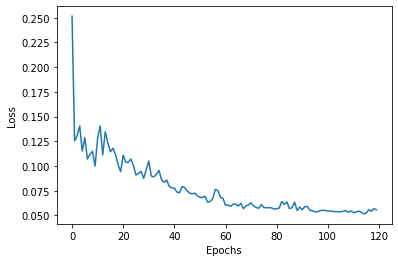

Get prediction data ^TNX done.
sftp local_path: /content/sample_data/^TNX_prediction.csv destination_path: /home/nexys/graphtrek/stock/^TNX_prediction.csv
sftp local_path: /content/sample_data/^TNX_test_prediction.csv destination_path: /home/nexys/graphtrek/stock/^TNX_test_prediction.csv
[*********************100%***********************]  1 of 1 completed
Get Stock Price QQQ done.
Model /content/drive/MyDrive/models/QQQ_14_1_indicators_10.h5 does not exists.
Model /content/drive/MyDrive/models/QQQ_14_1_indicators_10.h5 compiled.
Saved model /content/drive/MyDrive/models/QQQ_14_1_indicators_10.h5


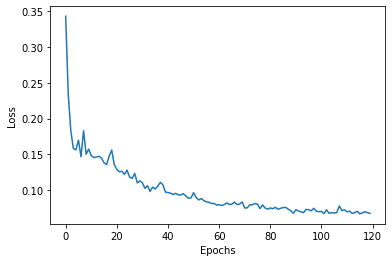

Get prediction data QQQ done.
sftp local_path: /content/sample_data/QQQ_prediction.csv destination_path: /home/nexys/graphtrek/stock/QQQ_prediction.csv
sftp local_path: /content/sample_data/QQQ_test_prediction.csv destination_path: /home/nexys/graphtrek/stock/QQQ_test_prediction.csv
[*********************100%***********************]  1 of 1 completed
Get Stock Price SPY done.
Model /content/drive/MyDrive/models/SPY_14_1_indicators_10.h5 does not exists.
Model /content/drive/MyDrive/models/SPY_14_1_indicators_10.h5 compiled.
Saved model /content/drive/MyDrive/models/SPY_14_1_indicators_10.h5


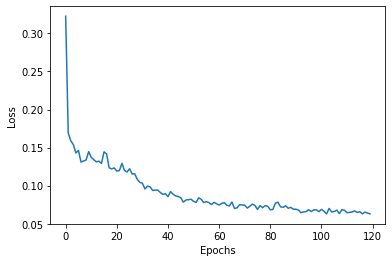

Get prediction data SPY done.
sftp local_path: /content/sample_data/SPY_prediction.csv destination_path: /home/nexys/graphtrek/stock/SPY_prediction.csv
sftp local_path: /content/sample_data/SPY_test_prediction.csv destination_path: /home/nexys/graphtrek/stock/SPY_test_prediction.csv
[*********************100%***********************]  1 of 1 completed
Get Stock Price IWM done.
Model /content/drive/MyDrive/models/IWM_14_1_indicators_10.h5 does not exists.
Model /content/drive/MyDrive/models/IWM_14_1_indicators_10.h5 compiled.
Saved model /content/drive/MyDrive/models/IWM_14_1_indicators_10.h5


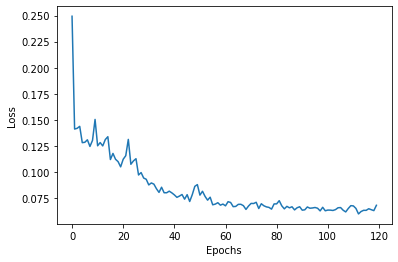

Get prediction data IWM done.
sftp local_path: /content/sample_data/IWM_prediction.csv destination_path: /home/nexys/graphtrek/stock/IWM_prediction.csv
sftp local_path: /content/sample_data/IWM_test_prediction.csv destination_path: /home/nexys/graphtrek/stock/IWM_test_prediction.csv
[*********************100%***********************]  1 of 1 completed
Get Stock Price ^VIX done.
Model /content/drive/MyDrive/models/^VIX_14_1_indicators_10.h5 does not exists.
Model /content/drive/MyDrive/models/^VIX_14_1_indicators_10.h5 compiled.
Saved model /content/drive/MyDrive/models/^VIX_14_1_indicators_10.h5


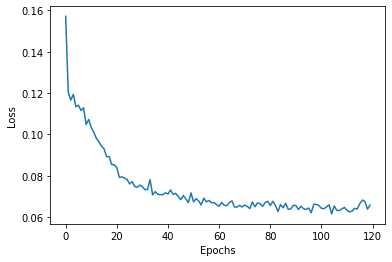

Get prediction data ^VIX done.
sftp local_path: /content/sample_data/^VIX_prediction.csv destination_path: /home/nexys/graphtrek/stock/^VIX_prediction.csv
sftp local_path: /content/sample_data/^VIX_test_prediction.csv destination_path: /home/nexys/graphtrek/stock/^VIX_test_prediction.csv
[*********************100%***********************]  1 of 1 completed
Get Stock Price TSLA done.
Model /content/drive/MyDrive/models/TSLA_14_1_indicators_10.h5 does not exists.
Model /content/drive/MyDrive/models/TSLA_14_1_indicators_10.h5 compiled.
Saved model /content/drive/MyDrive/models/TSLA_14_1_indicators_10.h5


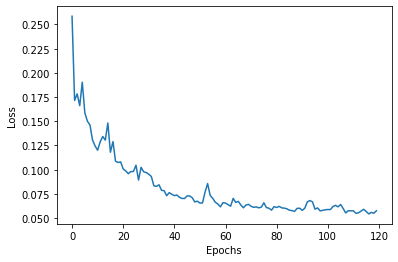

Get prediction data TSLA done.
sftp local_path: /content/sample_data/TSLA_prediction.csv destination_path: /home/nexys/graphtrek/stock/TSLA_prediction.csv
sftp local_path: /content/sample_data/TSLA_test_prediction.csv destination_path: /home/nexys/graphtrek/stock/TSLA_test_prediction.csv
[*********************100%***********************]  1 of 1 completed
Get Stock Price VTI done.
Model /content/drive/MyDrive/models/VTI_14_1_indicators_10.h5 does not exists.
Model /content/drive/MyDrive/models/VTI_14_1_indicators_10.h5 compiled.
Saved model /content/drive/MyDrive/models/VTI_14_1_indicators_10.h5


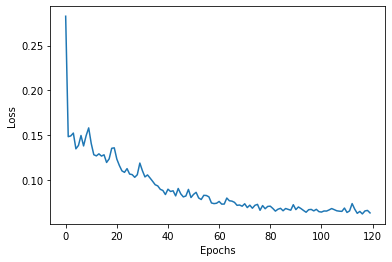

Get prediction data VTI done.
sftp local_path: /content/sample_data/VTI_prediction.csv destination_path: /home/nexys/graphtrek/stock/VTI_prediction.csv
sftp local_path: /content/sample_data/VTI_test_prediction.csv destination_path: /home/nexys/graphtrek/stock/VTI_test_prediction.csv
[*********************100%***********************]  1 of 1 completed
Get Stock Price XLE done.
Model /content/drive/MyDrive/models/XLE_14_1_indicators_10.h5 does not exists.
Model /content/drive/MyDrive/models/XLE_14_1_indicators_10.h5 compiled.
Saved model /content/drive/MyDrive/models/XLE_14_1_indicators_10.h5


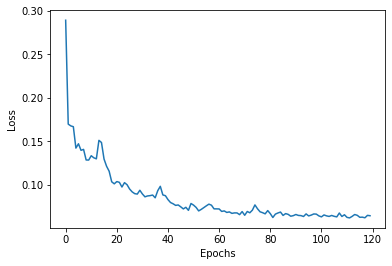

Get prediction data XLE done.
sftp local_path: /content/sample_data/XLE_prediction.csv destination_path: /home/nexys/graphtrek/stock/XLE_prediction.csv
sftp local_path: /content/sample_data/XLE_test_prediction.csv destination_path: /home/nexys/graphtrek/stock/XLE_test_prediction.csv
[*********************100%***********************]  1 of 1 completed
Get Stock Price XLF done.
Model /content/drive/MyDrive/models/XLF_14_1_indicators_10.h5 does not exists.
Model /content/drive/MyDrive/models/XLF_14_1_indicators_10.h5 compiled.
Saved model /content/drive/MyDrive/models/XLF_14_1_indicators_10.h5


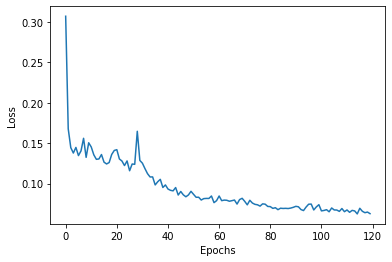

Get prediction data XLF done.
sftp local_path: /content/sample_data/XLF_prediction.csv destination_path: /home/nexys/graphtrek/stock/XLF_prediction.csv
sftp local_path: /content/sample_data/XLF_test_prediction.csv destination_path: /home/nexys/graphtrek/stock/XLF_test_prediction.csv
[*********************100%***********************]  1 of 1 completed
Get Stock Price TQQQ done.
Model /content/drive/MyDrive/models/TQQQ_14_1_indicators_10.h5 does not exists.
Model /content/drive/MyDrive/models/TQQQ_14_1_indicators_10.h5 compiled.
Saved model /content/drive/MyDrive/models/TQQQ_14_1_indicators_10.h5


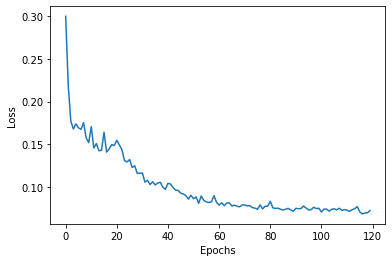

Get prediction data TQQQ done.
sftp local_path: /content/sample_data/TQQQ_prediction.csv destination_path: /home/nexys/graphtrek/stock/TQQQ_prediction.csv
sftp local_path: /content/sample_data/TQQQ_test_prediction.csv destination_path: /home/nexys/graphtrek/stock/TQQQ_test_prediction.csv
[*********************100%***********************]  1 of 1 completed
Get Stock Price BTC-USD done.
Model /content/drive/MyDrive/models/BTC-USD_14_1_indicators_10.h5 does not exists.
Model /content/drive/MyDrive/models/BTC-USD_14_1_indicators_10.h5 compiled.
Saved model /content/drive/MyDrive/models/BTC-USD_14_1_indicators_10.h5


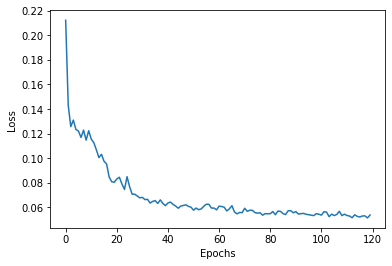

Get prediction data BTC-USD done.
sftp local_path: /content/sample_data/BTC-USD_prediction.csv destination_path: /home/nexys/graphtrek/stock/BTC-USD_prediction.csv
sftp local_path: /content/sample_data/BTC-USD_test_prediction.csv destination_path: /home/nexys/graphtrek/stock/BTC-USD_test_prediction.csv
[*********************100%***********************]  1 of 1 completed
Get Stock Price ETH-USD done.
Model /content/drive/MyDrive/models/ETH-USD_14_1_indicators_10.h5 does not exists.
Model /content/drive/MyDrive/models/ETH-USD_14_1_indicators_10.h5 compiled.
Saved model /content/drive/MyDrive/models/ETH-USD_14_1_indicators_10.h5


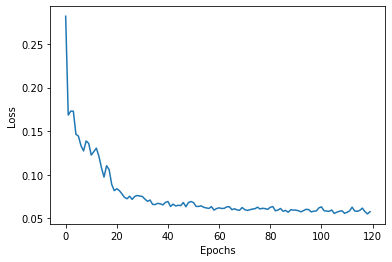

Get prediction data ETH-USD done.
sftp local_path: /content/sample_data/ETH-USD_prediction.csv destination_path: /home/nexys/graphtrek/stock/ETH-USD_prediction.csv
sftp local_path: /content/sample_data/ETH-USD_test_prediction.csv destination_path: /home/nexys/graphtrek/stock/ETH-USD_test_prediction.csv


In [26]:
symbols = ['^TNX','QQQ','SPY','IWM','^VIX','TSLA','VTI','XLE','XLF','TQQQ','BTC-USD','ETH-USD']

symbols1 = ['ABBV','AFRM','AMD','AMZN','APPS','ASTR','ATVI','BNGO',
           'CAT','CCL','CHWY','COST','CRM',
           'DIA','DIS','DKNG','ETSY','FFND','HOG','HUT','JETS','LOGI',
           'LVS','MSFT','MU','NCLH','NFLX','NKE','NVDA','PLTR','PYPL','XLNX',
           'RBLX','RKLB','SNAP','SOFI','SQ','TWTR','U','UBER','WFC','WBA','V']

symbols2 = ['AAPL','ARKG','ARKK','ARKQ','BA','CHPT','COIN','DDOG',
           'DOCU','EA','FB','GOOGL','ENPH','DT']

symbols3 = ['MA','MP','MRNA','MSTR','NNDM','HOOD','MCD','MARA', 'F']

symbols4 = ['PFE','PINS','ROKU','SBUX','SHOP','SOXL','SOXX']

symbols5 = ['TDOC','TEN','TGT','TLT','TTD','UAA',
           'VALE','WMT','WYNN','ZM']

symbols6 = ['PENN','QCOM','LCID','AAL']

symbols7 = ['V']


#forecast_rsi(symbols)
forecast_rsi(symbols1)
forecast_rsi(symbols2)
forecast_rsi(symbols3)
forecast_rsi(symbols4)
forecast_rsi(symbols5)
forecast_rsi(symbols6)
forecast_rsi(symbols7)

#upload_options(symbols)
#upload_options(symbols1)
#upload_options(symbols2)
#upload_options(symbols3)
#upload_options(symbols4)
#upload_options(symbols5)
#upload_options(symbols6)
#upload_options(symbols7)

#save_charts(symbols,False)
#save_charts(symbols1,False)
#save_charts(symbols2,False)
#save_charts(symbols3,False)
#save_charts(symbols4,False)
#save_charts(symbols5,False)
#save_charts(symbols6,False)
#save_charts(symbols7,False)